In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from eumap.misc import find_files, ttprint, nan_percentile, GoogleSheet
from eumap.raster import read_rasters, save_rasters
import warnings
import multiprocess as mp
import time
from scipy.special import expit, logit
import warnings
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, cross_val_score, HalvingGridSearchCV, KFold, GroupKFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
import joblib
import pickle
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from cubist import Cubist
from sklearn.base import BaseEstimator, TransformerMixin
from pathlib import Path

### input
space = 'log1p'
prop = 'N'
filt = 5
folder = 'http://192.168.1.30:8333/ai4sh-landmasked/model_benchmark'
output_folder = f'/mnt/primus/xuemeng_tmp_harbour/soc/results/{prop}'
# df = pd.read_csv(f'/mnt/primus/xuemeng_tmp_harbour/soc/data/002_data_whole.csv',low_memory=False)
test_size = 0

# import os
# os.makedirs(output_folder, exist_ok=True)

if space=='log1p':
    # df.loc[:,f'{prop}_log1p'] = np.log1p(df[prop])
    tgt = f'{prop}_log1p'
else:
    tgt = prop

In [3]:
cal = pd.read_csv(f'/mnt/primus/xuemeng_tmp_harbour/soc/results/N/benchmark_cal.pnts_N.csv',low_memory=False)
test = pd.read_csv(f'/mnt/primus/xuemeng_tmp_harbour/soc/results/N/benchmark_test.pnts_N.csv',low_memory=False)
train = pd.read_csv(f'/mnt/primus/xuemeng_tmp_harbour/soc/results/N/benchmark_train.pnts_N.csv',low_memory=False)

covs_a = pd.read_csv(f'{output_folder}/benchmark_selected.covs_N.txt').values.tolist()
covs = [item for sublist in covs_a for item in sublist]

In [4]:
rf = joblib.load('/mnt/primus/xuemeng_tmp_harbour/soc/results/N/model_rf.N_log1p.ccc.joblib')
rf_weighted = joblib.load('/mnt/primus/xuemeng_tmp_harbour/soc/results/N/model_rf.N_log1p.ccc.weighted.joblib')
ann = joblib.load('/mnt/primus/xuemeng_tmp_harbour/soc/results/N/model_ann.N_log1p.ccc.joblib')
lgbmd= joblib.load('/mnt/primus/xuemeng_tmp_harbour/soc/results/N/model_lgb.N_log1p.ccc.joblib')
lgbmd_weighted = joblib.load('/mnt/primus/xuemeng_tmp_harbour/soc/results/N/model_lgb.N_log1p.ccc.weighted.joblib')

models = [rf, ann, lgbmd, rf_weighted, lgbmd_weighted]
model_names = ['rf', 'ann', 'lgb', 'rf_weighted', 'lgb_weighted']   

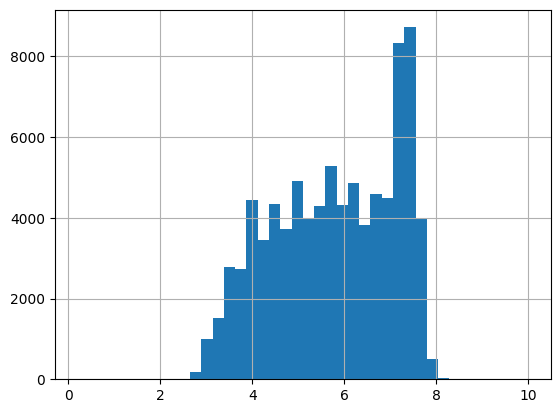

In [6]:
### data set preparation
# clean the data according to each properties
df = df.loc[df[prop].notna()]
df = df.loc[df[f'{prop}_qa']>filt]
df[prop].hist(bins=40)
# set target variable
if space=='log1p':
    df.loc[:,f'{prop}_log1p'] = np.log1p(df[prop])
    tgt = f'{prop}_log1p'
else:
    tgt = prop
        
# split calibration, train and test for benchmark
bd_val = pd.read_csv(f'{folder}/material/003.0_validate.pnts.rob_bd.csv',low_memory=False)
oc_val = pd.read_csv(f'{folder}/material/003.1_validate.pnts.rob_soc.csv',low_memory=False)
idl = bd_val['id'].values.tolist() + oc_val['id'].values.tolist()
idl = [str(i) for i in idl]
test = df.loc[df['id'].isin(idl)] # individual test datasets
cal_train = df.loc[~df['id'].isin(idl)] # calibration and train
# get 10% of training data as calibration for parameter fine tuning and feature selection
cal_train.reset_index(drop=True, inplace=True)
cal = cal_train.groupby('tile_id', group_keys=False).apply(lambda x: x.sample(n=max(1, int(np.ceil(0.1 * len(x))))))
# the rest as training dataset
train = cal_train.drop(cal.index)

# if test_size>0:
#     test = test.iloc[0:round(len(test)*test_size)]
#     train = train.iloc[0:round(len(train)*test_size)]
#     cal = cal.iloc[0:round(len(cal)*test_size)]

cal.to_csv(f'{output_folder}/benchmark_cal.pnts_{prop}.csv',index=False)
train.to_csv(f'{output_folder}/benchmark_train.pnts_{prop}.csv',index=False)
test.to_csv(f'{output_folder}/benchmark_test.pnts_{prop}.csv',index=False)

In [7]:
### feature selection
def calc_ccc(y_true, y_pred):
    mean_true = np.mean(y_true)
    mean_pred = np.mean(y_pred)
    cov_matrix = np.cov(y_true, y_pred)
    covariance = cov_matrix[0, 1]
    var_true = cov_matrix[0, 0]
    var_pred = cov_matrix[1, 1]
    ccc = (2 * covariance) / (var_true + var_pred + (mean_true - mean_pred) ** 2)
    return ccc
ccc_scorer = make_scorer(calc_ccc, greater_is_better=True)

In [8]:
def run_rankcv(data, covs, tgt, spatial_cv_column, weights_feature=None, n_bootstrap=20, ntrees = 100):

    groups = data[spatial_cv_column].unique()
    runs = []
    
    # loop on different bootstrap
    for k in range(n_bootstrap):
        
        np.random.seed(k)
        selected_groups = np.random.choice(groups, int(len(groups) * 0.7), False)  # each time cover 70% of the tiles
        samples_train = data[data[spatial_cv_column].isin(selected_groups)]
        train = samples_train.groupby(spatial_cv_column, group_keys=False).apply(lambda x: x.sample(min(len(x), 20)))  # make sure to select enough data for training
        
        ttprint(f'{k} iteration, training size: {len(train)}')
        # Get weights if applicable
        if weights_feature:
            weights = train[weights_feature].to_numpy()
            rf = RandomForestRegressor(random_state=41, n_jobs=80, n_estimators=ntrees)
            rf.fit(train[covs], train[tgt], sample_weight=weights)
        else:
            rf = RandomForestRegressor(random_state=41, n_jobs=80, n_estimators=ntrees)
            rf.fit(train[covs], train[tgt])

        importances = pd.Series(rf.feature_importances_, index=covs).sort_values(ascending=True)
        importances = importances[importances>=importances.mean()]
        runs.append((importances.index, np.array(importances.to_list())))
        
    result = pd.DataFrame(
        dict(feature=[feature for run in runs for feature in run[0]], 
             importance=[importance for run in runs for importance in run[1]])
    )

    return result

def find_knee(df):
    slopes = (df['accum'].diff(-1)) / (df['freq'].diff(-1))*(-1)
    knee_index = slopes.idxmax()
    return knee_index

covs_a = pd.read_csv(f'{folder}/material/001_covar_all.txt').values.tolist()
covs_all = [item for sublist in covs_a for item in sublist]
cal = cal.dropna(subset=covs_all,how='any')

result_rankcv = run_rankcv(cal, covs_all, tgt, spatial_cv_column='tile_id')
feature_list = result_rankcv.groupby(['feature']).count().rename(columns=dict(importance='freq')).reset_index()
features_freq = feature_list.groupby('freq').count().reset_index().sort_values(by='freq', ascending=False)
features_freq['accum'] = features_freq['feature'].cumsum()
knee_index = find_knee(features_freq)
knee_freq = features_freq.loc[knee_index]['freq']
covs = feature_list[feature_list['freq']>=knee_freq]['feature'].tolist() # choose only those with high frequency
# save for records
with open(f'{output_folder}/benchmark_selected.covs_{prop}.txt', 'w') as file:
    for item in covs:
        file.write(f"{item}\n")


[20:56:30] 0 iteration, training size: 7061
[20:56:39] 1 iteration, training size: 6977
[20:56:49] 2 iteration, training size: 7021
[20:56:58] 3 iteration, training size: 7103
[20:57:08] 4 iteration, training size: 7069
[20:57:18] 5 iteration, training size: 6968
[20:57:27] 6 iteration, training size: 7064
[20:57:36] 7 iteration, training size: 7071
[20:57:47] 8 iteration, training size: 7102
[20:57:57] 9 iteration, training size: 6996
[20:58:06] 10 iteration, training size: 7033
[20:58:17] 11 iteration, training size: 7036
[20:58:26] 12 iteration, training size: 7128
[20:58:35] 13 iteration, training size: 7088
[20:58:47] 14 iteration, training size: 7102
[20:58:56] 15 iteration, training size: 6998
[20:59:06] 16 iteration, training size: 7094
[20:59:15] 17 iteration, training size: 7018
[20:59:25] 18 iteration, training size: 7015
[20:59:34] 19 iteration, training size: 7112


In [9]:
models = [] #[rf, ann, lgb, rf_weighted, lgb_weighted] #cubist, cubist_weighted, 
model_names = [] #['rf', 'ann', 'lgb', 'rf_weighted', 'lgb_weighted'] # 'cubist',, 'cubist_weighted'

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.model_selection import HalvingRandomSearchCV

### parameter fine tuning
spatial_cv_column = 'tile_id'
cv = GroupKFold(n_splits=5)
fitting_score = ccc_scorer
## no weights version
# random forest
param_rf = {
    'n_estimators': [60, 80, 100],
    'max_depth': [10, 20, 30],
    'max_features': [0.3, 0.5, 0.7, 'log2', 'sqrt'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
# {
#     'n_estimators': [60, 80, 100],
#     "criterion": [ "squared_error", "absolute_error", "poisson"],
#     "max_depth": randint(5, 100),
#     "max_features": uniform(loc=0, scale=1),
#     "min_samples_split": randint(2, 40),
#     "min_samples_leaf": randint(1, 10)
# }

tune_rf = HalvingGridSearchCV(
    estimator=RandomForestRegressor(),
    param_grid=param_rf,
    scoring=fitting_score,
    n_jobs=90, 
    cv=cv,
    verbose=1,
    random_state = 1992
)

# tune_rf = RandomizedSearchCV(
#     estimator=RandomForestRegressor(random_state=42),
#     param_distributions=param_rf,
#     scoring=fitting_score,
#     n_jobs=90, 
#     cv=cv,
#     verbose=1,
#     random_state=1987
# )
tune_rf.fit(cal[covs], cal[tgt], groups=cal[spatial_cv_column])
warnings.filterwarnings('ignore')
rf = tune_rf.best_estimator_
joblib.dump(rf, f'{output_folder}/model_rf.{prop}_{space}.ccc.joblib')
models.append(rf)
model_names.append('rf')


# simple ANN
warnings.filterwarnings('ignore')
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPRegressor(max_iter=5000, early_stopping=True, random_state=28))
])
param_ann = {
    'mlp__hidden_layer_sizes': [(50,), (100,), (100, 50), (100, 100)],  # NN structure
    'mlp__activation': ['tanh', 'relu'],  # commonly used activation functions in NN
    'mlp__solver': ['sgd'],  # optimizer set as sgd
    'mlp__alpha': [0.0001, 0.001, 0.01],  # regularization to prevent overfitting
    'mlp__learning_rate': ['constant', 'adaptive'],  # how aggressive the weights update
    'mlp__learning_rate_init': [0.001, 0.01]  # initial learning rate
    
}
# tune_ann = RandomizedSearchCV(
#     estimator=pipeline,
#     param_distributions=param_ann,
#     scoring=fitting_score,
#     n_jobs=90,
#     cv=cv,
#     verbose=1,
#     random_state=1988
# )
tune_ann = HalvingGridSearchCV(
    estimator=pipeline,
    param_grid=param_ann,
    scoring=fitting_score,
    n_jobs=90,
    cv=cv,
    verbose=1,
    random_state=1993
)
tune_ann.fit(cal[covs], cal[tgt], groups=cal[spatial_cv_column])
ann = tune_ann.best_estimator_
joblib.dump(ann, f'{output_folder}/model_ann.{prop}_{space}.ccc.joblib')
models.append(ann)
model_names.append('ann')




n_iterations: 5
n_required_iterations: 6
n_possible_iterations: 5
min_resources_: 43
max_resources_: 10472
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 405
n_resources: 43
Fitting 5 folds for each of 405 candidates, totalling 2025 fits
----------
iter: 1
n_candidates: 135
n_resources: 129
Fitting 5 folds for each of 135 candidates, totalling 675 fits
----------
iter: 2
n_candidates: 45
n_resources: 387
Fitting 5 folds for each of 45 candidates, totalling 225 fits
----------
iter: 3
n_candidates: 15
n_resources: 1161
Fitting 5 folds for each of 15 candidates, totalling 75 fits
----------
iter: 4
n_candidates: 5
n_resources: 3483
Fitting 5 folds for each of 5 candidates, totalling 25 fits
n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 129
max_resources_: 10472
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 96
n_resources: 129
Fitting 5 folds for each of 96 candidates, totalling 480 fits
----------
it

In [35]:
# # lightGBR
import lightgbm as lgb
def clean_feature_names(df):
    df.columns = [col.replace('{', '').replace('}', '').replace(':', '').replace(',', '').replace('"', '') for col in df.columns]
    return df
from sklearn.preprocessing import FunctionTransformer
clean_names_transformer = FunctionTransformer(clean_feature_names, validate=False)
pipeline = Pipeline([
    ('clean_names', clean_names_transformer),  # Clean feature names
    ('lgbm', lgb.LGBMRegressor(random_state=35,verbose=-1))         # Replace with any model you intend to use
])
param_lgb = {
    'lgbm__n_estimators': [80, 100, 120],  # Lower initial values for quicker testing
    'lgbm__max_depth': [3, 5, 7],  # Lower maximum depths
    'lgbm__num_leaves': [20, 31, 40],  # Significantly fewer leaves
    'lgbm__learning_rate': [0.01, 0.05, 0.1],  # Fine as is, covers a good range
    'lgbm__min_child_samples': [20, 30, 50],  # Much lower values to accommodate small data sets
    'lgbm__subsample': [0.8, 1.0],  # Reduced range, focusing on higher subsampling
    'lgbm__colsample_bytree': [0.8, 1.0],  # Less variation, focus on higher values
    'lgbm__verbosity': [-1]
}

tune_lgb = HalvingGridSearchCV(
    estimator=pipeline,
    param_grid=param_lgb,
    scoring=fitting_score,
    n_jobs=90,
    cv=cv,
    verbose=-1,
    random_state=1994
)
# tune_lgb = RandomizedSearchCV(
#     estimator = pipeline,
#     scoring = fitting_score,
#     param_distributions = param_lgb,
#     # factor = 2,
#     # verbose = 1,
#     # min_resources = 1000,
#     # max_resources = 20000,
#     cv = cv,
#     random_state=1994
# )

tune_lgb.fit(cal[covs], cal[tgt], groups=cal[spatial_cv_column])
lgbmd = tune_lgb.best_estimator_
joblib.dump(lgbmd, f'{output_folder}/model_lgb.{prop}_{space}.ccc.joblib')
models.append(lgbmd)
model_names.append('lgb')

In [ ]:
# ## weighted version
# sample_weights = cal[f'{prop}_qa'].values**2
# # random forest
# tune_rf.fit(cal[covs], cal[tgt], sample_weight=sample_weights, groups=cal[spatial_cv_column])
# rf_weighted = tune_rf.best_estimator_
# joblib.dump(rf_weighted, f'{output_folder}/model_rf.{prop}_{space}.ccc.weighted.joblib')
# models.append(rf_weighted)
# model_names.append('rf_weighted')



# lightGBM
fit_params = {'lgbm__sample_weight': sample_weights}
tune_lgb.fit(cal[covs], cal[tgt], **fit_params, groups=cal[spatial_cv_column])
lgbmd_weighted = tune_lgb.best_estimator_
joblib.dump(lgbmd_weighted, f'{output_folder}/model_lgb.{prop}_{space}.ccc.weighted.joblib')
models.append(lgbmd_weighted)
model_names.append('lgb_weighted')

In [8]:
import lightgbm as lgb
### validate on individual test and CV
def accuracy_plot(y_test, y_pred, title, show_range = [0, 7], vmax=20):
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    ccc = calc_ccc(y_test, y_pred)
    
    plt.rcParams.update({'font.size': 16})
    fig = plt.figure(figsize=(8, 8), constrained_layout=True)
    fig.suptitle(title, fontsize=20, fontweight='bold')
    plt.title(f'R2={r2:.2f}, RMSE={rmse:.2f}, CCC={ccc:.2f}')
    plt.hexbin(y_test, y_pred, gridsize=(150, 150), cmap='plasma_r', mincnt=1, vmax=vmax)
    
    plt.xlabel('true')
    plt.ylabel('pred')
    
    ax = plt.gca()
    ax.set_aspect('auto', adjustable='box')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.plot(show_range, show_range, "-k", alpha=.5)
    
    cax = fig.add_axes([ax.get_position().x1 + 0.05, ax.get_position().y0, 0.02, ax.get_position().height])
    cb = plt.colorbar(cax=cax)
    
    plt.savefig(f'{output_folder}/plot_accuracy_{title}.pdf', format='pdf', dpi=300)
    return r2, rmse, ccc


def error_spatial_plot(y_test, y_pred, lat, lon, title, latbox=[33, 72], lonbox=[-12, 35]):
    y_error = y_pred - y_test
    fig, ax = plt.subplots(figsize=(11, 8))
    
    # Create the hexbin plot
    hexbin = ax.hexbin(lon, lat, C=y_error, gridsize=100, cmap='seismic', mincnt=1, 
                       reduce_C_function=np.mean)
    
    ax.set_xlabel('Longitude', fontsize=14)
    ax.set_ylabel('Latitude', fontsize=14)
    ax.set_title(f'{title} - error', fontsize=16)
    
    if latbox is not None:
        ax.set_ylim(latbox)
    if lonbox is not None:
        ax.set_xlim(lonbox)
    
    colorbar = plt.colorbar(hexbin)
    colorbar.set_label(f'Prediction Error', fontsize=14)
    
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'{output_folder}/plot_error.spatial_{title}.pdf', format='pdf', dpi=300)


# use sorted plot to check extrapolation problem
def sorted_plot(y_test, y_pred, title):
    # Sort values for a cleaner plot
    sorted_indices = np.argsort(y_test) # sort according to true y values, get the sorted index
    sorted_y_test = np.array(y_test)[sorted_indices] # sort with the index
    sorted_y_pred = y_pred[sorted_indices]

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(sorted_y_test)), sorted_y_pred, 'or', label='Predicted Values')
    plt.plot(range(len(sorted_y_test)), sorted_y_test, 'k-', label='True Values', alpha=0.4)

    # Formatting
    plt.title(f'check end values of {title}')
    plt.xlabel('Data Points (sorted by true values)')
    plt.ylabel('Predicted/True Values')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'{output_folder}/plot_sorted_{title}.pdf', format='pdf', dpi=300)
    


train = train.dropna(subset=covs,how='any')
test = test.dropna(subset=covs,how='any')



N.rf
N.ann
N.lgb
N.rf_weighted
N.lgb_weighted


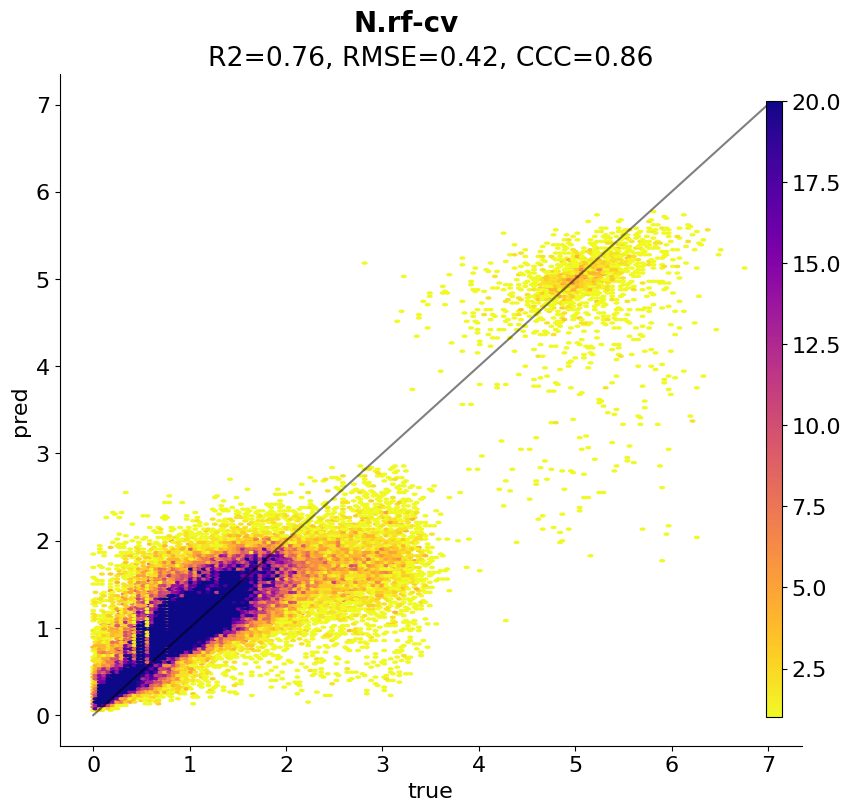

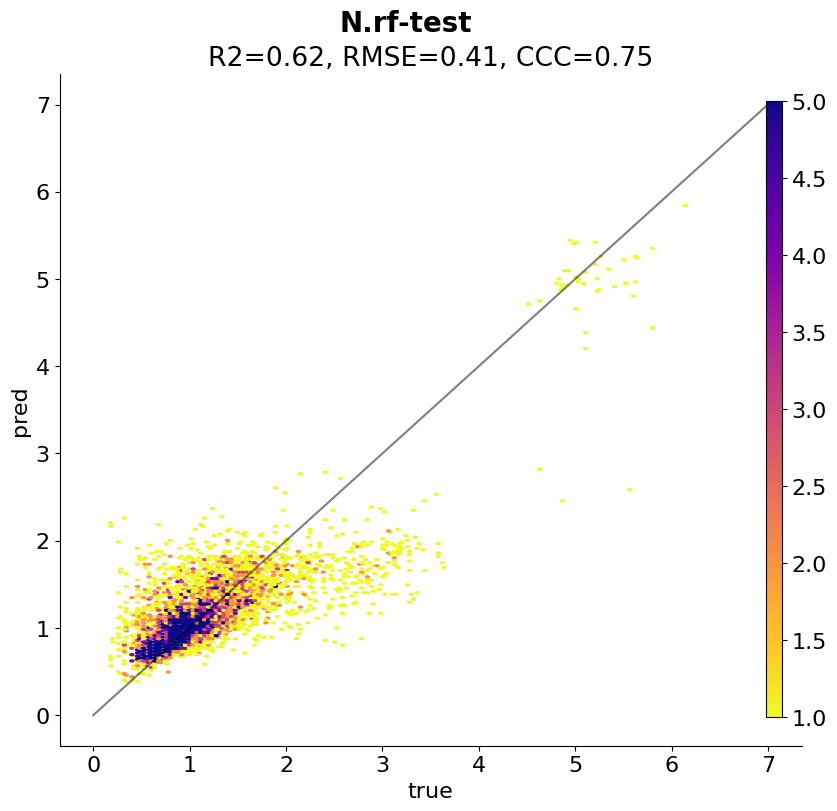

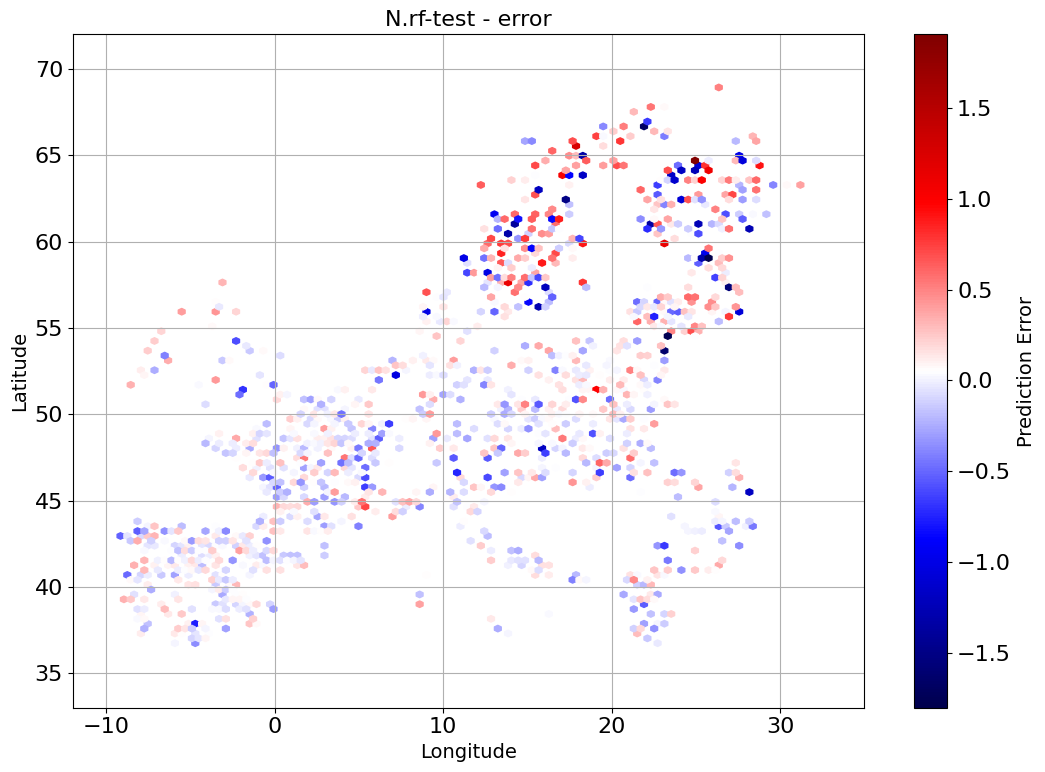

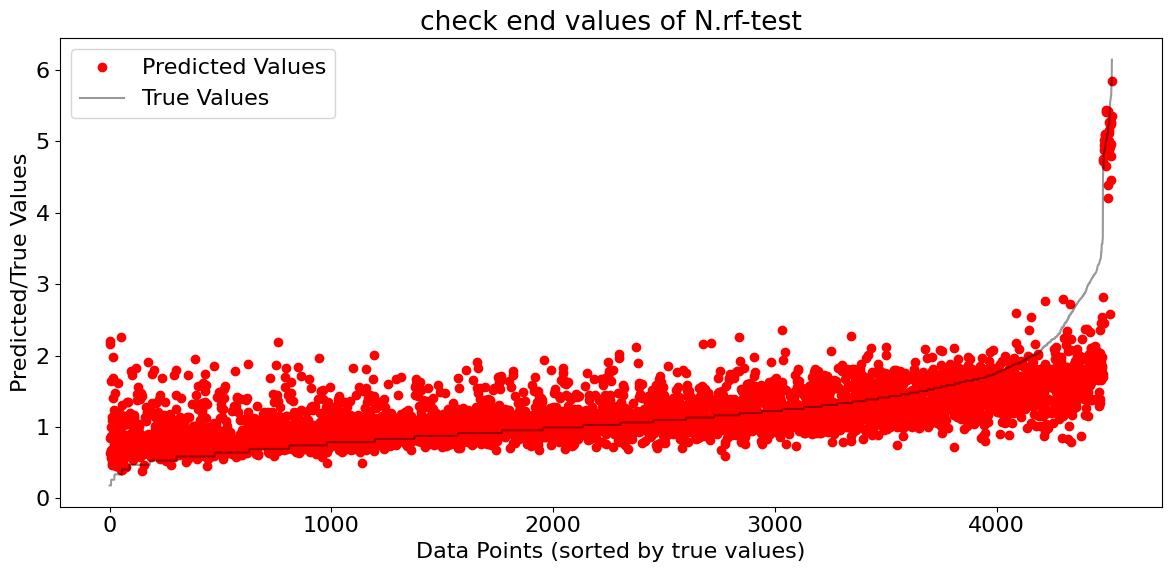

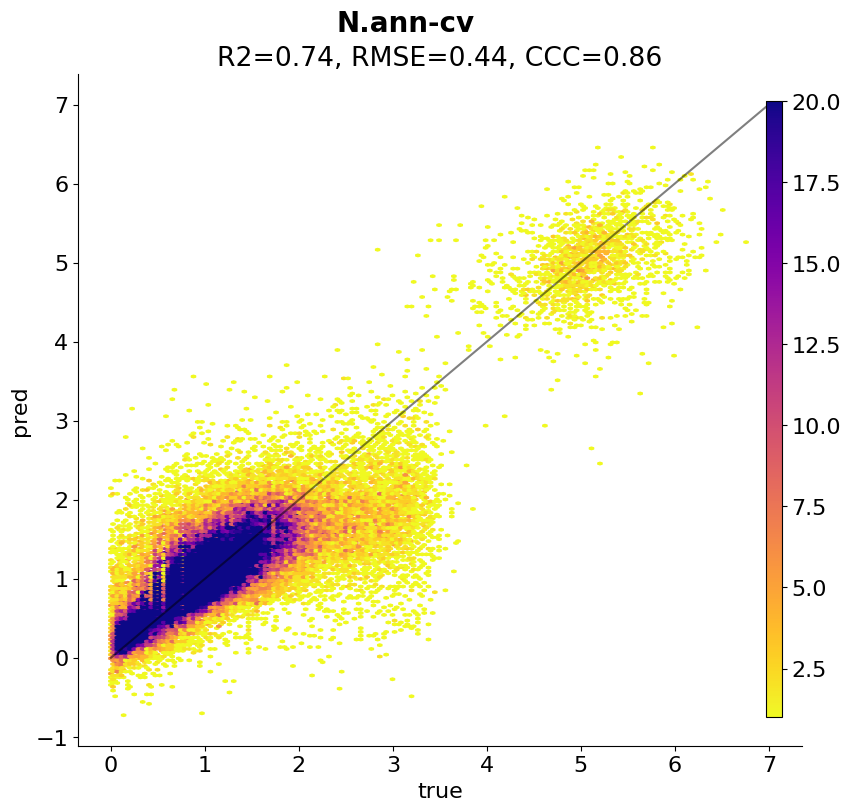

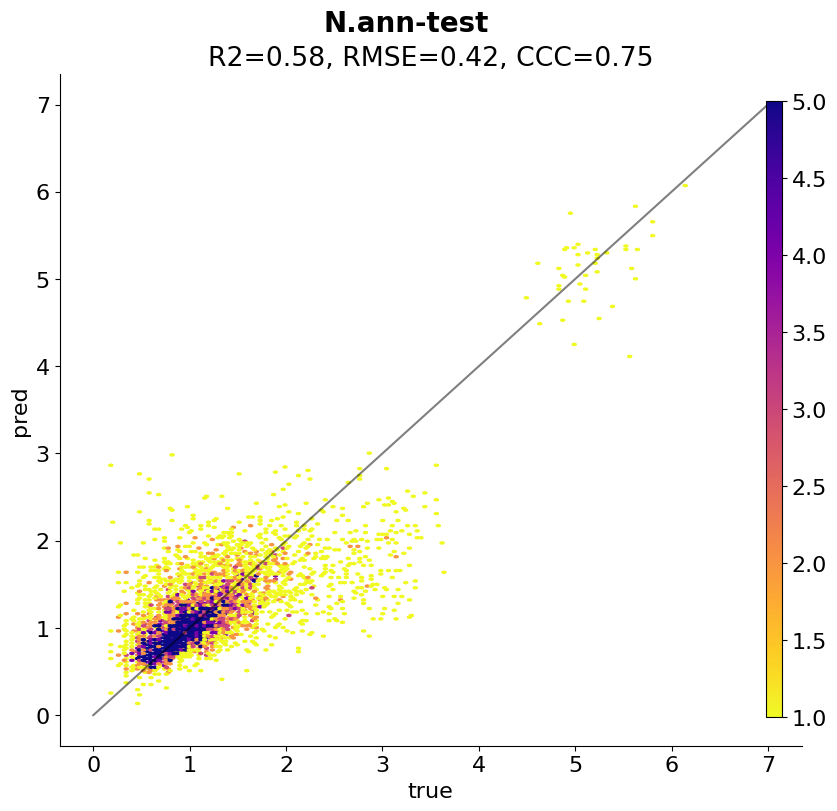

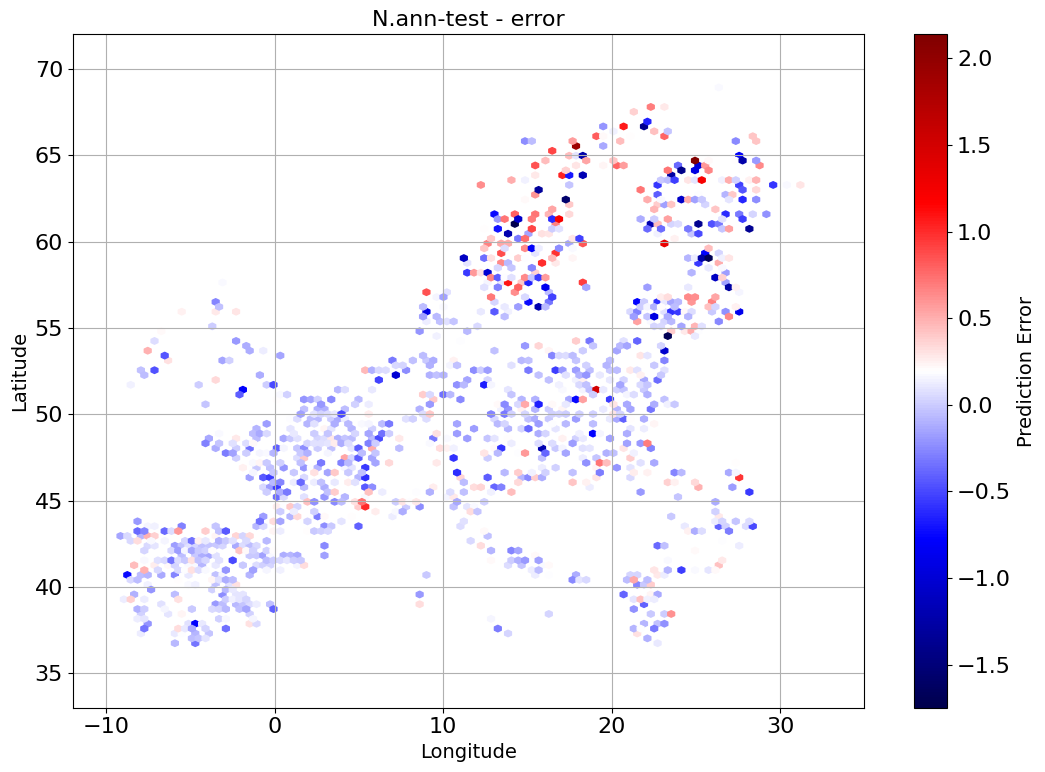

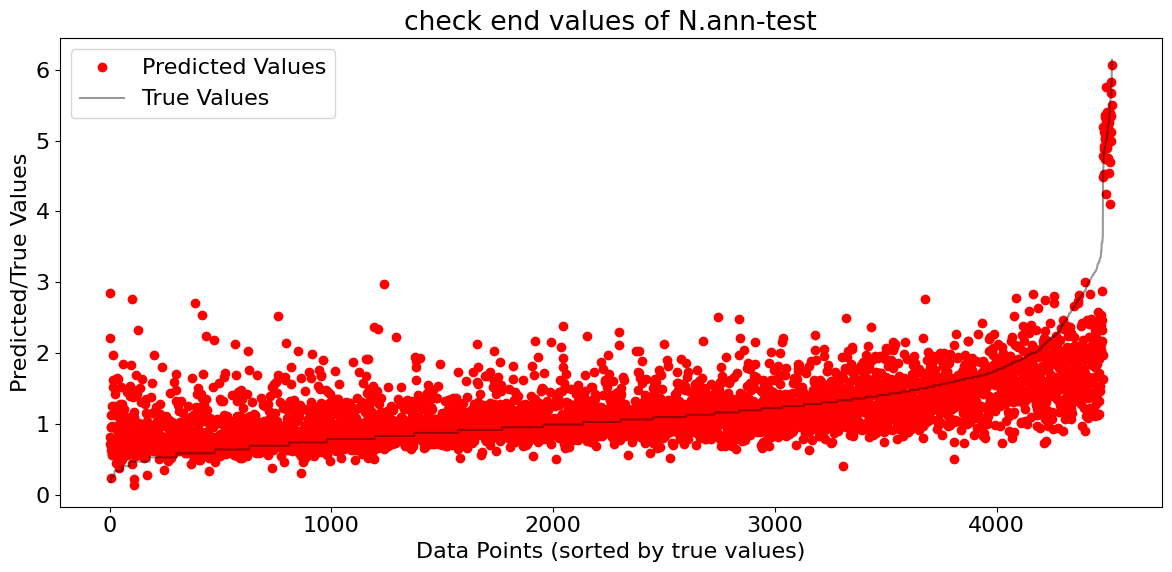

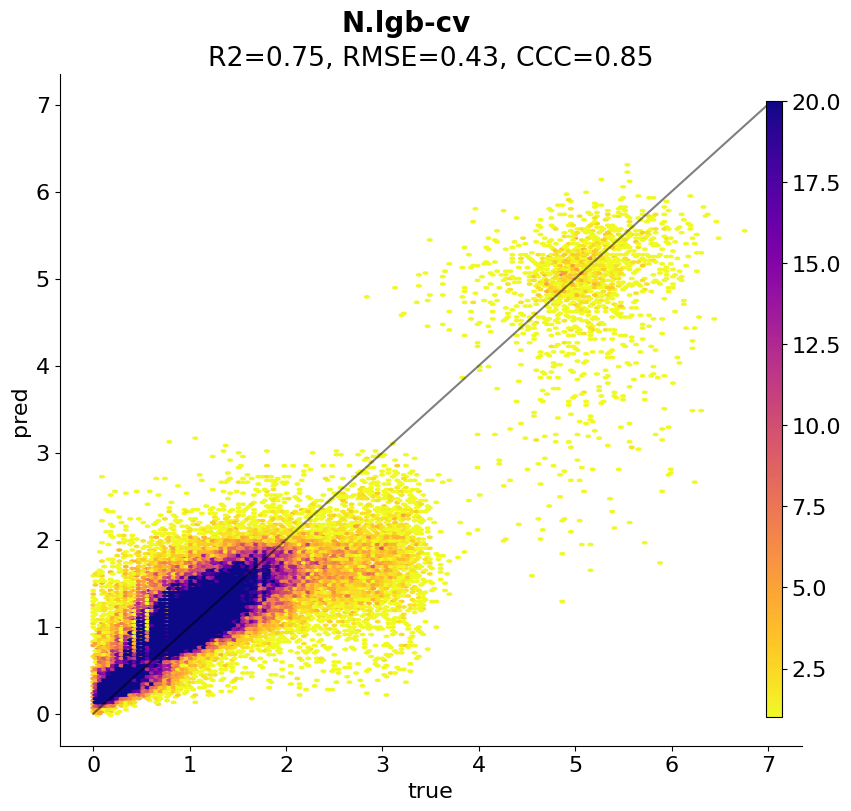

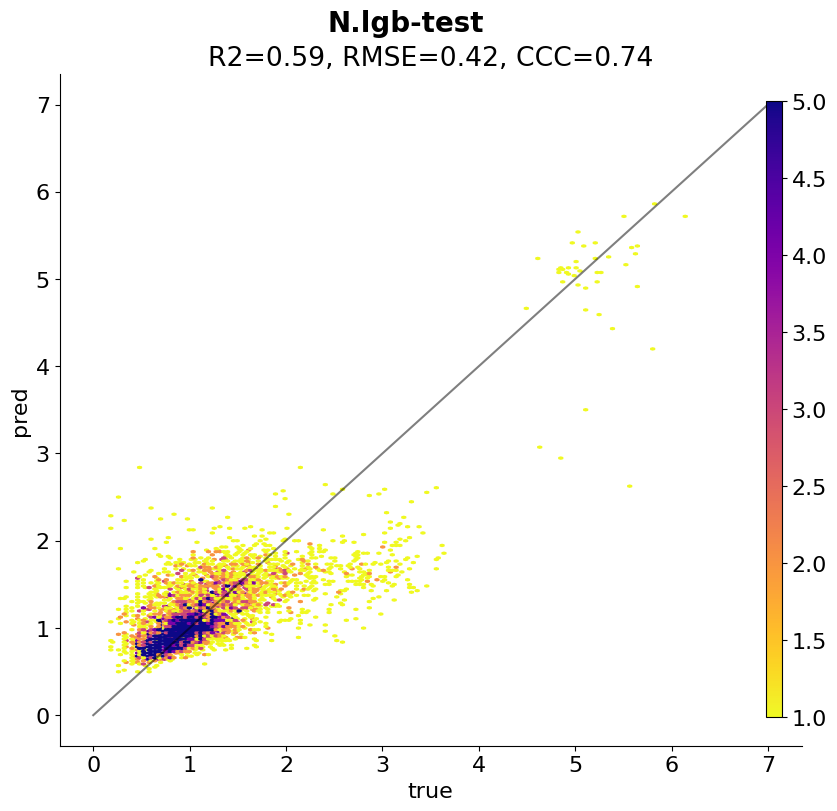

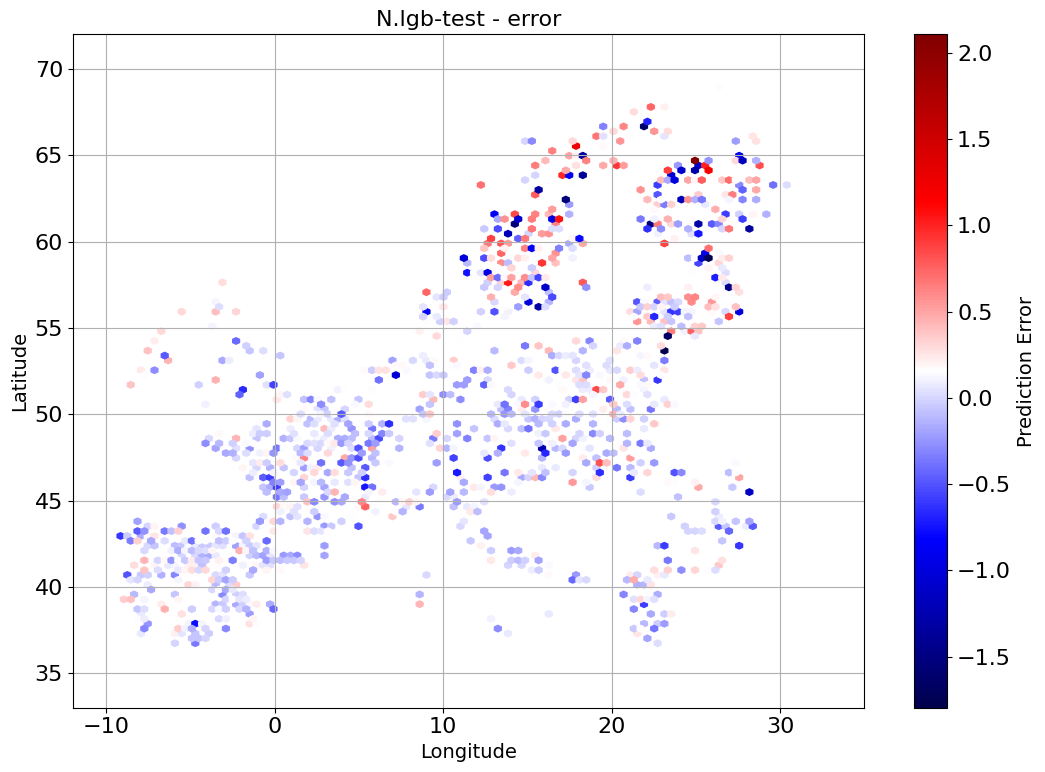

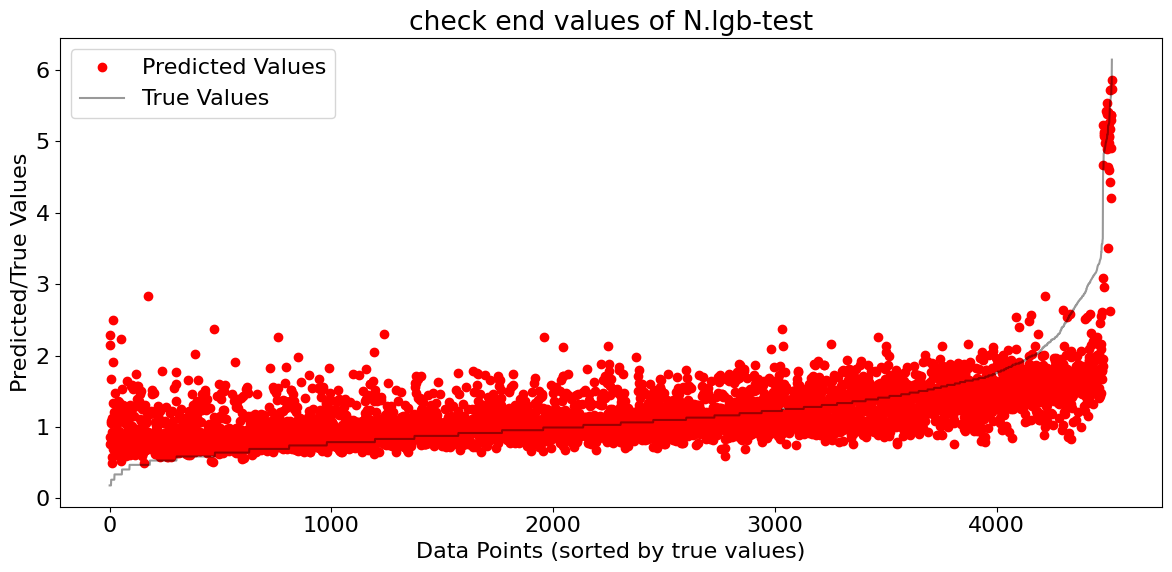

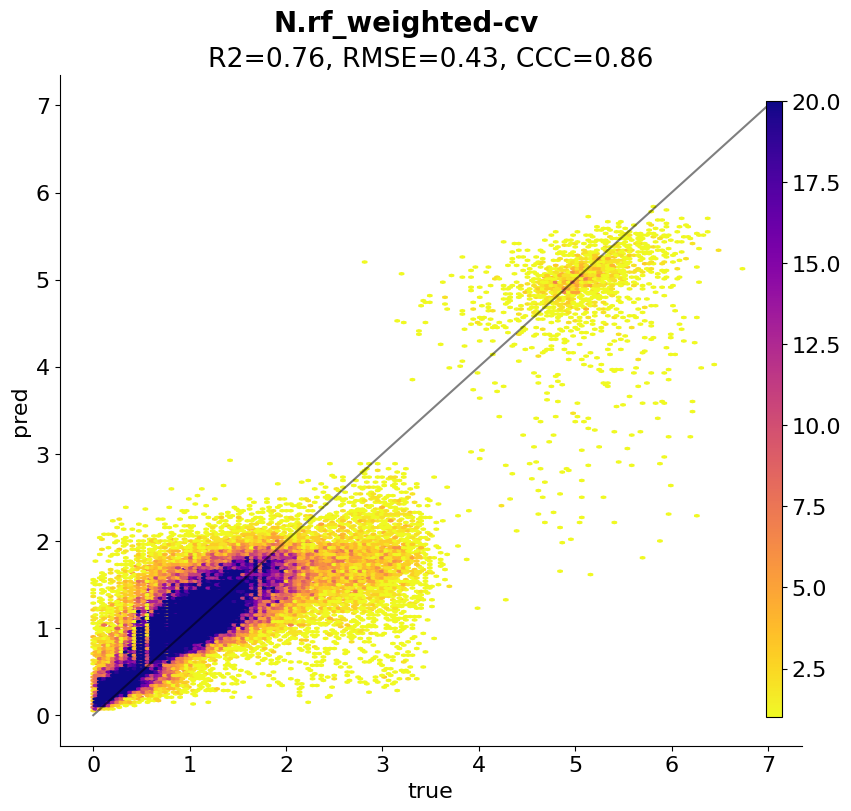

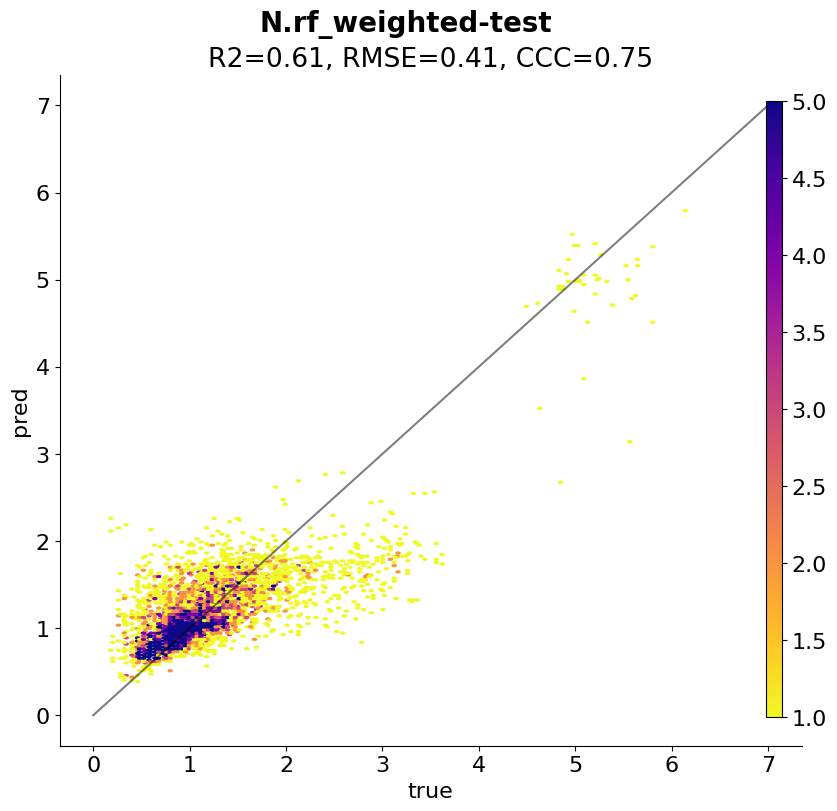

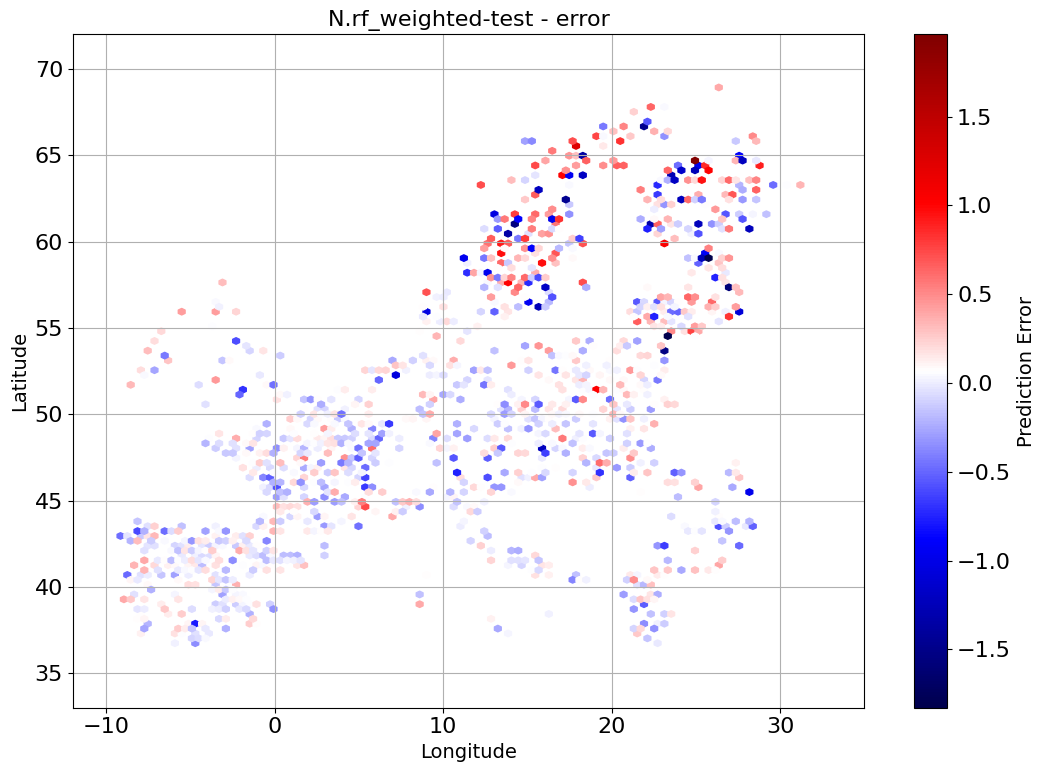

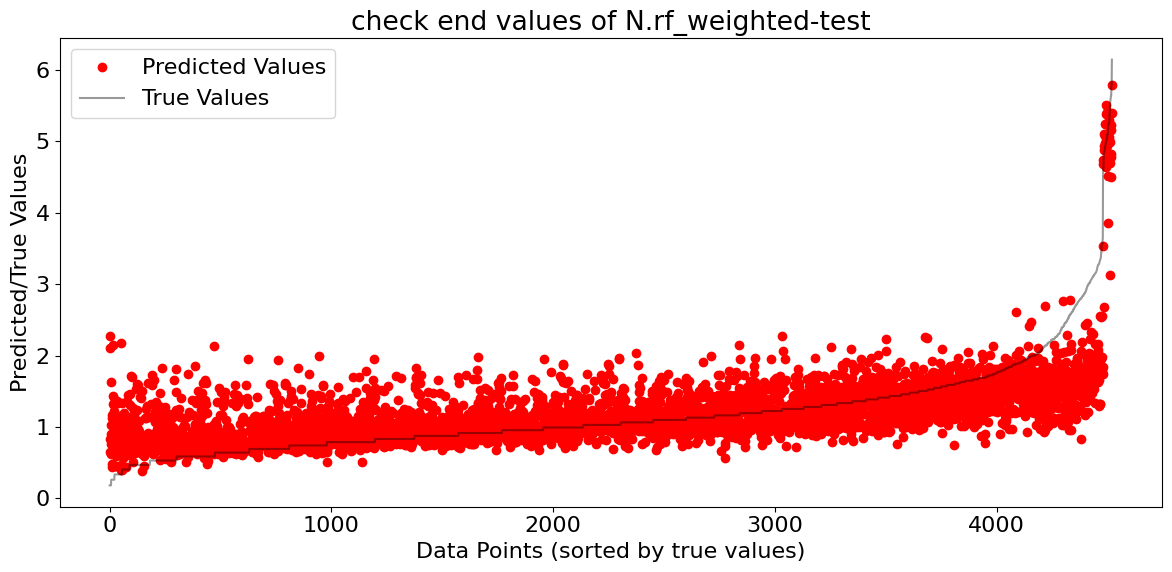

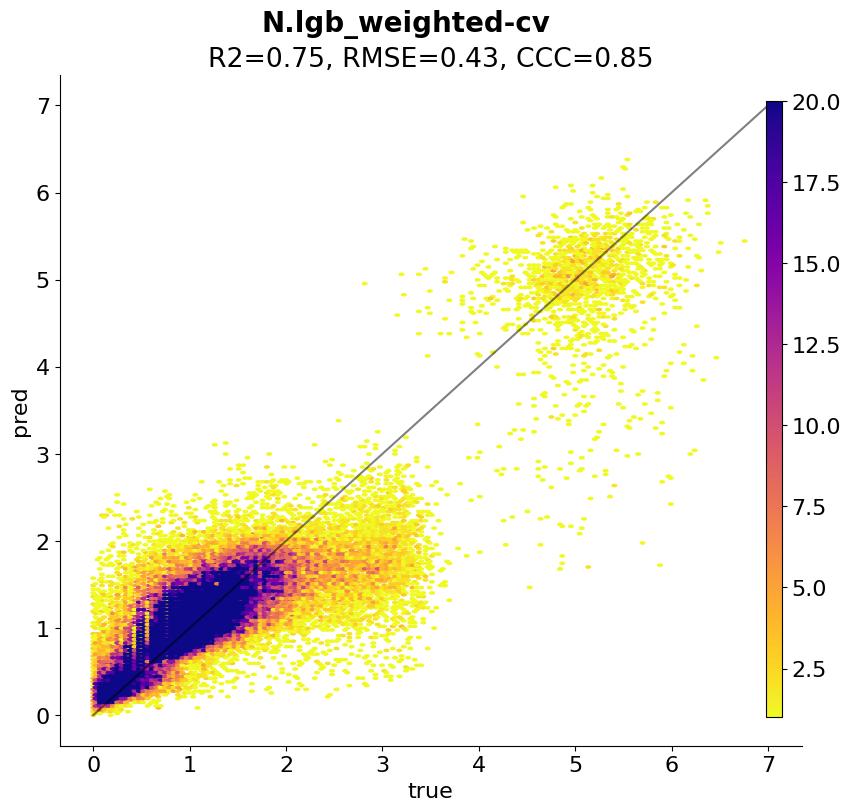

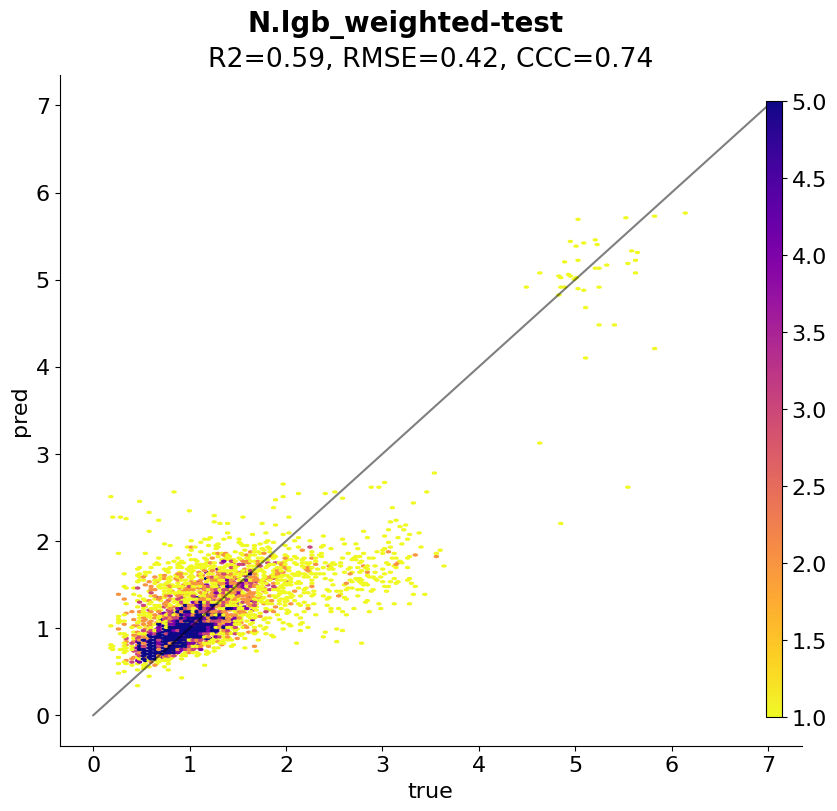

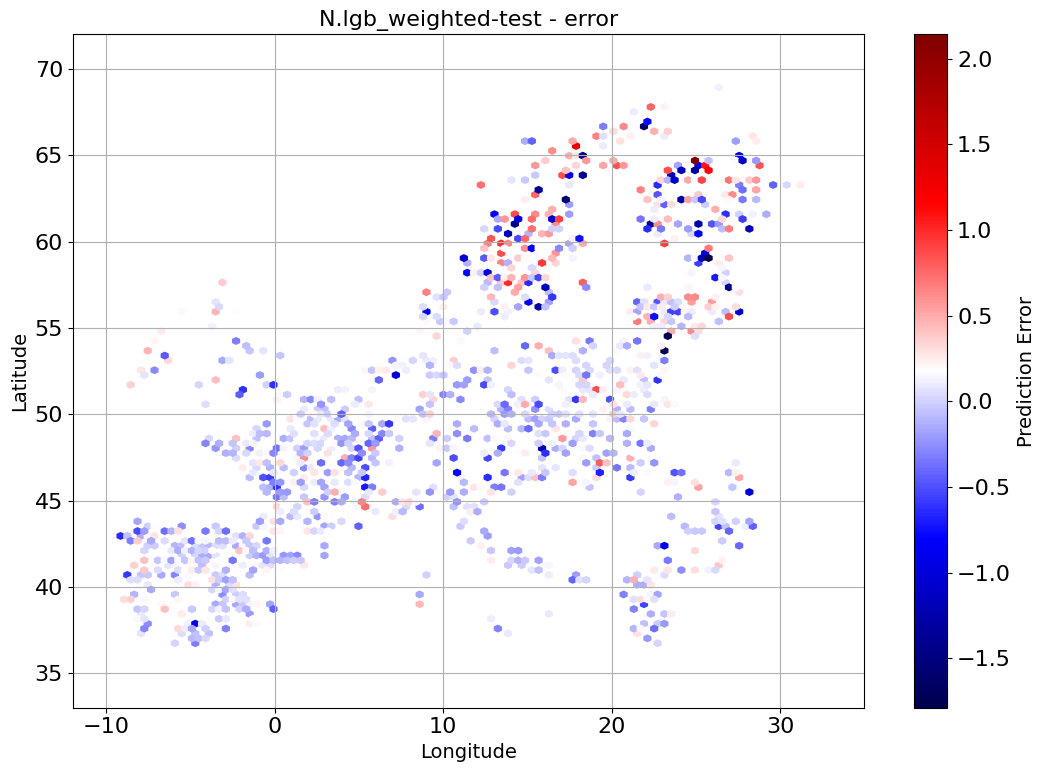

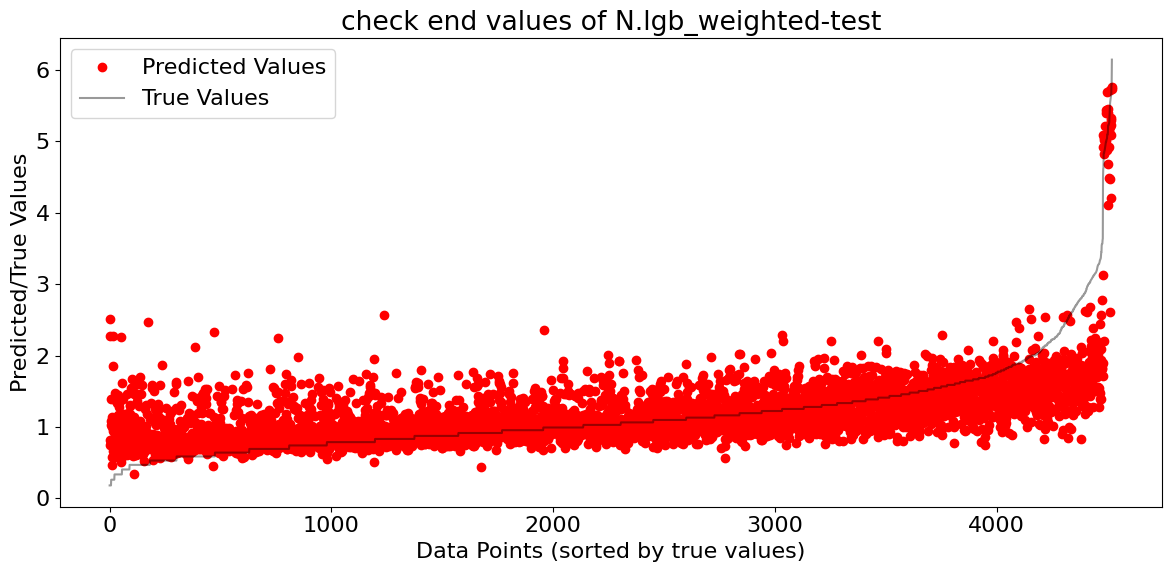

In [9]:
from sklearn.model_selection import cross_val_predict
import math
sample_weights = train[f'{prop}_qa'].values**2
results = []
show_low = math.floor(train[tgt].min())
show_high = math.ceil(train[tgt].max())
cv = GroupKFold(n_splits=5)
spatial_cv_column = 'tile_id'
fitting_score = ccc_scorer
for im in range(len(models)):
    model_name = model_names[im]
    model = models[im]
    figure_name = prop+'.'+model_name
    print(figure_name)
    fit_params = {}
    # Determine the last step name early if it's a pipeline
    if hasattr(model, 'named_steps'):
        last_step_name = list(model.named_steps.keys())[-1]
        if 'weighted' in model_name:
            fit_params = {f'{last_step_name}__sample_weight': sample_weights}
    elif 'weighted' in model_name:
        fit_params = {'sample_weight': sample_weights}
    
    start_time = time.time()
    y_pred_cv = cross_val_predict(model, train[covs], train[tgt], cv=cv, groups=train[spatial_cv_column], n_jobs=90, fit_params=fit_params)
    end_time = time.time()
    cv_time = (end_time - start_time)
    r2_cv, rmse_cv, ccc_cv = accuracy_plot(train[tgt], y_pred_cv, figure_name+ '-cv', show_range = [show_low, show_high], vmax=20) # visuliazation
    
    start_time = time.time()
    model.fit(train[covs], train[tgt], **fit_params)
    y_pred_val = model.predict(test[covs])
    end_time = time.time()
    testing_time = (end_time - start_time)
    r2_val, rmse_val, ccc_val = accuracy_plot(test[tgt], y_pred_val, figure_name+ '-test', show_range = [show_low, show_high], vmax=5) # visuliazation
    error_spatial_plot(test[tgt], y_pred_val, test['lat'], test['lon'], figure_name+ '-test')
    sorted_plot(test[tgt],y_pred_val, figure_name+ '-test')
    
    # store the metrics
    results.append({
        'title': model_name,
        'R2_val': r2_val,
        'RMSE_val': rmse_val,
        'CCC_val': ccc_val,
        'R2_cv': r2_cv,
        'RMSE_cv': rmse_cv,
        'CCC_cv': ccc_cv,
        'cv_time (s)': cv_time,
        'test_time (s)': testing_time
    })
    
    # store feature importance
    if hasattr(model, 'named_steps'):  # Check if it's a pipeline
        last_step = model.named_steps[last_step_name]
        if hasattr(last_step, 'feature_importances_'):
            importances = last_step.feature_importances_
    elif hasattr(model, 'feature_importances_'):  # Direct model
        importances = model.feature_importances_
    else:
        importances = [0] * len(covs)  # Default to zero if no importances are available

    feature_importance_df = pd.DataFrame({
        'feature': covs,
        'importance': importances
    })
    sorted_feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)
    sorted_feature_importance_df.to_csv(f'{output_folder}/feature.importances_{prop}_{model_name}.txt', index=False, sep='\t')
      
results = pd.DataFrame(results)
results.to_csv(f'{output_folder}/benchmark_metrics_{prop}.csv',index=False)
    
    

In [27]:
a = train.loc[train[tgt]==0]
a = a.loc[a['ref']=='LUCAS']
a['time'].unique()

array([2009., 2015.])